# Project 2, Part 5, Cleansing customer data

University of California, Berkeley

Master of Information and Data Science (MIDS) program

w205 - Fundamentals of Data Engineering

Student: Stephanie Cabanela

Year: 2022

Semester: Spring

Section: 7


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd
import psycopg2
import json
import csv
import matplotlib.pyplot as plt
from datetime import datetime as dt

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  

Remember you can freely use any code from the labs. You do not need to cite code from the labs.

In [2]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

cursor = connection.cursor()

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

# 2.5.1 Validate the city, state, and zip for stage_1_peak_customers against the zip_codes table

AGM does not want to give its customer list to 3rd party sales channels, including Peak Delivery.  For that reason, we can expect some variation in customer first and last names, and in the street.  However, the city, state, and zip should be validated by Peak's system, so we do not anticipate any issues.

Write a query that demonstrates that the city, state, and zip are valid for all records.  Like we did in 2.4, it's usually best to write a query that return errors.  In our case the query should not return anything.

Sort by stage_id

Pattern your code after the examples in the labs.  You may use as many code cells as you need.

In [59]:
rollback_before_flag = True
rollback_after_flag = True

query  = """

select *
from stage_1_peak_customers
where (city, state, zip) not in (select city, state, zip from zip_codes)
order by stage_id

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,customer_id,first_name,last_name,street,city,state,zip


# 2.5.2 Find all customer records in stage_1_peak_customers where any of first_name, last_name, and/or street do not match a customer in the customers table

AGM does not want to give its customer list to 3rd party sales channels, including Peak Delivery.  For that reason, we can expect some variation in customer first and last names, and in the street.  

Write a query that returns all customer records in state_1_peak_customers where any of the first_name, last_name, and/or street do not match a customer in the customers table

Sort by stage_id

Pattern your code after the examples in the labs.  You may use as many code cells as you need.

In [4]:
rollback_before_flag = True
rollback_after_flag = True

query  = """

select *
from stage_1_peak_customers
where first_name not in (select first_name from customers)
    or last_name not in (select last_name from customers)
    or street not in (select street from customers)
    or (first_name, last_name) not in (select first_name, last_name from customers)
    or (first_name, street) not in (select first_name, street from customers)
    or (last_name, street) not in (select last_name, street from customers)
    or (first_name, last_name, street) not in (select first_name, last_name, street from customers)
order by stage_id

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,customer_id,first_name,last_name,street,city,state,zip
0,10,5763728768,3729016,Hyrum,Knuckles,86668 Spenser Terrace,Oakland,CA,94618
1,20,5763728877,3728936,Roseann,Coyish,11707 American Ash Ter,Orinda,CA,94563
2,24,5763728428,3729287,Hali,Ducker,8 Orion Pass,El Cerrito,CA,94530
3,26,5763728393,3728674,Melantha,Golborn,6140 North Field Alley,Orinda,CA,94563
4,36,5763729212,3729191,Eleni,Jansen,66 Bartelt Hill,Oakland,CA,94607
5,40,5763729129,3728856,Clyve,Humonds,22 Brent Wood Hill,Berkeley,CA,94709
6,51,5763728864,3729178,Rutledge,Hellwing,606 Gulf Plz,El Cerrito,CA,94530
7,60,5763729313,3728402,Kalli,Kemel,18373 Golf View Pass,Berkeley,CA,94702
8,72,5763728980,3729213,Honina,Philson,28 Clarendon Plaza,Berkeley,CA,94702
9,73,5763728921,3729194,Nicky,Haley,88424 Warrior Lane,Oakland,CA,94602


# 2.5.3 Find the percentage of Peak's customer records that do not match to AGM's customers table

Write a query to find the percentage of Peak's customer records that do not match AGM's.  The percentage can be found by taking the number of customer records in stage_1_peak_customers that do not match and dividing by the number of customers records in stage_1_peak_customers and multiplying by 100.

Show the total number of Peak customer records in stage_1_peak_customers, the number that match to customers, the number that do not match to customers, and the percentage that do not match.

Show the percentage rounded to the nearest tenth.  It is not necessary to include a percent sign.

Pattern your code after the examples in the labs.  You may use as many code cells as you need.

In [5]:
rollback_before_flag = True
rollback_after_flag = True

query  = """

with stage_all_cust as (
        select count(*) as cust_count from stage_1_peak_customers
    ),
    stage_no_match as (
        select count(first_name) as no_match_count
        from stage_1_peak_customers
        where (first_name, last_name, street, city, state, zip) not in 
            (select first_name, last_name, street, city, state, zip 
            from customers)
    )
select cust_count::numeric as total_num_customers,
    cust_count::numeric - no_match_count::numeric as num_matching,
    no_match_count as num_not_matching,
    round((no_match_count::numeric/cust_count::numeric)*100, 1) as percentage
from stage_all_cust cross join stage_no_match

"""


my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,total_num_customers,num_matching,num_not_matching,percentage
0,97,84,13,13.4


# 2.5.4 Executive summary on customer data

Write an executive summary on the customer data.  

The summary should be the equivalent to 3/4 to 1 page using standard fonts, spacing, and margins. 

As stated in the scenario, like most companies, AGM does not want to give out its customer list to 3rd party sales channels.  The downside is, as we have seen, that customer first names, last names, and street addresses will have some variations and not be exact matches.

The executives would like your recommendation of one of the following:
* Continue to withhold the customer data from 3rd party sales channels
* Give customer data to 3rd party sales channels

Recommend exactly one of these.

Support you recommendation with an explanation based on what you have seen from this preliminary data load.

You are not required to write any queries nor create any data visualizations.  However, you may want to include some to enhance and add quality to your submission.  Submissions with these tend to be higher quality, although, not always.

You may use any number of code cells and/or markdown cells. 

You may alternate between code cells and markdown cells.  That is perfectly fine.  It is understood that before we present it, an editor would pull out the text, results of queries, and data visualizations.

In [6]:
rollback_before_flag = True
rollback_after_flag = True

query  = """

select *
from stage_1_peak_customers
where first_name not in (select first_name from customers)
    or last_name not in (select last_name from customers)
    or street not in (select street from customers)
    or (first_name, last_name) not in (select first_name, last_name from customers)
    or (first_name, street) not in (select first_name, street from customers)
    or (last_name, street) not in (select last_name, street from customers)
    or (first_name, last_name, street) not in (select first_name, last_name, street from customers)
order by stage_id

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,customer_id,first_name,last_name,street,city,state,zip
0,10,5763728768,3729016,Hyrum,Knuckles,86668 Spenser Terrace,Oakland,CA,94618
1,20,5763728877,3728936,Roseann,Coyish,11707 American Ash Ter,Orinda,CA,94563
2,24,5763728428,3729287,Hali,Ducker,8 Orion Pass,El Cerrito,CA,94530
3,26,5763728393,3728674,Melantha,Golborn,6140 North Field Alley,Orinda,CA,94563
4,36,5763729212,3729191,Eleni,Jansen,66 Bartelt Hill,Oakland,CA,94607
5,40,5763729129,3728856,Clyve,Humonds,22 Brent Wood Hill,Berkeley,CA,94709
6,51,5763728864,3729178,Rutledge,Hellwing,606 Gulf Plz,El Cerrito,CA,94530
7,60,5763729313,3728402,Kalli,Kemel,18373 Golf View Pass,Berkeley,CA,94702
8,72,5763728980,3729213,Honina,Philson,28 Clarendon Plaza,Berkeley,CA,94702
9,73,5763728921,3729194,Nicky,Haley,88424 Warrior Lane,Oakland,CA,94602


In [55]:
rollback_before_flag = True
rollback_after_flag = True

query  = """

select *
from customers
where street like '%86668%'

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,customer_id,first_name,last_name,street,city,state,zip,closest_store_id,distance
0,281,Hiram,Knuckles,86668 Spenser Terrace,Oakland,CA,94618,1,1


In [74]:
rollback_before_flag = True
rollback_after_flag = True

query  = """

select *
from stage_1_peak_customers
order by customer_id desc
limit 50

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,customer_id,first_name,last_name,street,city,state,zip
0,28,5763729200,3729342,Kari,Charon,13771 Basil Road,Oakland,CA,94606
1,9,5763728696,3729340,Lanni,Pickavant,481 Moose Pass,Oakland,CA,94609
2,85,5763728938,3729316,Lin,Mortell,92 Oak Alley,Oakland,CA,94612
3,2,5763729036,3729309,Moria,Greenwood,8803 Delaware Crossing,Berkeley,CA,94705
4,32,5763728580,3729292,Sawyere,Ballintyne,2659 Northport Crossing,Albany,CA,94706
5,61,5763729209,3729288,Levy,MacIan,4 Bonner Plaza,El Cerrito,CA,94530
6,24,5763728428,3729287,Hali,Ducker,8 Orion Pass,El Cerrito,CA,94530
7,6,5763729051,3729276,Christian,Anyene,869 Transport Crossing,Berkeley,CA,94707
8,33,5763729211,3729247,Glynis,Banker,65 South Junction,Oakland,CA,94606
9,31,5763728865,3729246,Candy,Ben,1479 Bartillon Plaza,Oakland,CA,94602


# Customer Data Executive Summary
Based on initial inspection of the sample customer data from Peak Deliveries, I recommend that we continue to withhold the customer data from 3rd party sales channels. This is because I was able to perform data cleansing that rendered the Peak customer data satisfactory for data analysis. The data cleansing process revealed the following characteristics of the Peak customer data, which I will go into more detail:

* Passes basic validation
* No duplicates
* Small proportion of peak customer data had misspellings that can be corrected via basic data cleansing

### Validation
Since AGM does not want to give its customer list to 3rd party channels, we expected some variation in customer first names, last names, and street. We verified that the remaining columns including city, state, and zip code are valid for Peak customer records by checking them against AGM’s `zip_codes` table. We confirmed that each city, state, zip combination from Peak Deliveries matches the corresponding AGM zip codes. That is, the number of invalid Peak customer rows is zero.

In [17]:
rollback_before_flag = True
rollback_after_flag = True

query  = """

select count(*) as num_invalid
from stage_1_peak_customers
where (city, state, zip) not in (select city, state, zip from zip_codes)

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,num_invalid
0,0




### No Duplicates
During our data exploration, we verified that there were no duplicates in the Peak customer data by making sure that the first name, last name combinations were unique and that the customer IDs were unique.

In [32]:
rollback_before_flag = True
rollback_after_flag = True

query  = """

select count(count_total) as num_duplicate_names
from (select first_name, last_name, count(*) as count_total
    from stage_1_peak_customers
    group by first_name, last_name
    having count(*) > 1) as temp

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,num_duplicate_names
0,0


In [34]:
rollback_before_flag = True
rollback_after_flag = True

query  = """

select count(count_total) as num_duplicate_cust_id
from (select customer_id, count(*) as count_total
    from stage_1_peak_customers
    group by customer_id
    having count(*) > 1) as temp

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,num_duplicate_cust_id
0,0


### Identifying Mismatches
As anticipated, we encountered some mismatches in customer names and streets when comparing Peak Deliveries customer data to AGM customer data. When comparing the Peak data against AGM’s customers table, we found a total of 13 mismatches. However, upon further inspection of each mismatched record, we found that all mismatches were misspellings that can be reconciled.

In [40]:
rollback_before_flag = True
rollback_after_flag = True

query  = """

select count(*) as num_mismatches
from stage_1_peak_customers
where (first_name, last_name, street, city, state, zip) not in 
    (select first_name, last_name, street, city, state, zip 
    from customers)

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,num_mismatches
0,13


In [47]:
rollback_before_flag = True
rollback_after_flag = True

query  = """

with stage_all_cust as (
        select count(*) as cust_count from stage_1_peak_customers
    ),
    stage_no_match as (
        select count(first_name) as no_match_count
        from stage_1_peak_customers
        where (first_name, last_name, street, city, state, zip) not in 
            (select first_name, last_name, street, city, state, zip 
            from customers)
    )
select cust_count::numeric as total_num_customers,
    cust_count::numeric - no_match_count::numeric as num_matching,
    no_match_count as num_not_matching,
    round((no_match_count::numeric/cust_count::numeric)*100, 1) as percentage
from stage_all_cust cross join stage_no_match

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,total_num_customers,num_matching,num_not_matching,percentage
0,97,84,13,13.4


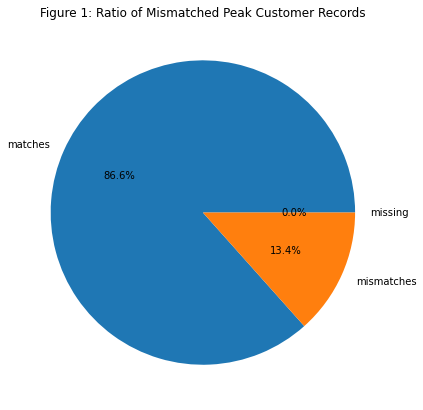

In [57]:
num_matches = df.iloc[0][1]
num_mismatches = df.iloc[0][2]
num_missing = 0

values = [num_matches, num_mismatches, num_missing]
labelS_df = ['matches', 'mismatches', 'missing']

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
plt.figure(figsize=(7,7))
plt.pie(values, labels=labelS_df, autopct='%1.1f%%')
plt.title('Figure 1: Ratio of Mismatched Peak Customer Records')
plt.show()

TODO: try using Levenstein distance to calculate difference between records in each table; address whether a 13.4% mismatch is of concern. Maybe acknowledge that this might be a more tedious process for a larger dataset? Or try to find the matches in a more efficient way using Levenstein distance or fuzzy logic or something.

### Conclusion
Our findings on the initial Peak Delivery data has shown that with some data cleansing, the Peak Delivery customer data is acceptable for performaing data analysis. The Peak data exhibited the following during the cleansing process: it passed validation against AGM's `zip_codes` table, there were no duplicate records, there were no mising records when checked against AGM's `customers` table, and any mismatches were results of misspellings that could easily be corrected. Therefore, since we are able to match records from both the AGM and Peak customer tables (i.e. we are not suffering from data loss), I recommend that we continue to withhold the customer data from 3rd party sales channels.

In [ ]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select stage_id,
    stage_name_string,
    customer_name_string,
    levenshtein(stage_name_string, customer_name_string) as levenshtein_name,
    stage_street,
    customer_street,
    levenshtein(stage_street, customer_street) as levenshtein_street
from (select cu1.stage_id as stage_id,
       concat(cu1.first_name, ' ', cu1.last_name) as stage_name_string,
       concat(cu2.first_name, ' ', cu2.last_name) as customer_name_string,
       cu1.street as stage_street,
       cu2.street as customer_street,
       cu1.city as stage_city,
       cu1.state as stage_state,
       cu1.zip as stage_zip,
       cu2.city as customer_city,
       cu2.state as customer_state,
       cu2.zip as customer_zip
from stage_1_peak_customers as cu1
     join customers as cu2
         on levenshtein(cu1.first_name, cu2.first_name) < 5 and levenshtein(cu1.last_name, cu2.last_name) < 5
order by cu1.stage_id) as temp
where stage_city = customer_city
    and stage_state = customer_state
    and stage_zip = customer_zip
    and (
        levenshtein(stage_street, customer_street) = 0
        and levenshtein(stage_name_string, customer_name_string) > 0
        and levenshtein(stage_name_string, customer_name_string) < 10
    ) or
    (    
        levenshtein(stage_name_string, customer_name_string) = 0
        and levenshtein(stage_street, customer_street) > 0
        and levenshtein(stage_street, customer_street) < 10
    ) or (
        levenshtein(stage_name_string, customer_name_string) > 0
        and levenshtein(stage_name_string, customer_name_string) < 5
        and levenshtein(stage_street, customer_street) > 0
        and levenshtein(stage_street, customer_street) < 5
    )
order by stage_id


"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)